## SLAYER Auto Example for training Spiking MLP on subset of NMNIST digits
### The problem:
Training digit classifier(0-9) on a subset(1000 training and 100 testing) of NMNIST digit spikes recorded using DVS camera. Just change the training and testing list for full NMNIST training.

## Load required modules
* SLAYER auto modules are available as `snn.auto`.{`loihi`, `dataset`, `assistant`}

In [1]:
import sys, os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
import torch
from torch.utils.data import Dataset, DataLoaderb
import slayerSNN as snn
import slayerSNN.auto # this can be referenced as snn.auto

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-0v8rwwuc because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Describe the network

In [2]:
netDesc = {
    'simulation' : {'Ts': 1, 'tSample': 350},
    'neuron' : {
        'type'     : 'LOIHI',
        'vThMant'  : 80,
        'vDecay'   : 128,
        'iDecay'   : 1024,
        'refDelay' : 1,
        'wgtExp'   : 0,
        'tauRho'   : 1,
        'scaleRho' : 1,
    },
    'layer' : [
        {'dim' : '34x34x2'},
        {'dim' : 512},
        {'dim' : 512},
        {'dim' : 11},
    ],
    'training' : {
        'error' : {
            'type' : 'NumSpikes',
            'tgtSpikeRegion' : {'start': 0, 'stop': 300},
            'tgtSpikeCount' : {True: 60, False: 10},
        }
    }
}

netParams = snn.params(dict=netDesc)

## Extract NMNISTsmall dataset
This is a subset of NMNIST dataset containing first 1000 training samples and first 100 testing samples. The original NMNSIT dataset consists of full MNIST samples converted into spikes using DVS sensor moved in three repeatable saccadic motion. For details and full dataset download links, refer to [https://www.garrickorchard.com/datasets/n-mnist](https://www.garrickorchard.com/datasets/n-mnist)

In [3]:
with zipfile.ZipFile('NMNISTsmall.zip') as zip_file:
    for member in zip_file.namelist():
        if not os.path.exists('./' + member):
            zip_file.extract(member, './')

## Dataset Definition
This is general dataset definition, different from standard PyTorch dataset definition. The dataset should return a numpy event array in (x, y, p, t(ms)) format and the class label. It will be wrapped by `slayer.auto.dataset` for PyTorch training.

In [4]:
class nmnistDataset():
    def __init__(self, datasetPath, train=True):
        self.path = datasetPath 
        if train is True:
            self.samples = np.loadtxt(datasetPath + '/train1K.txt').astype('int')
        else:
            self.samples = np.loadtxt(datasetPath + '/test100.txt').astype('int')

    def __getitem__(self, index):
        # Read inoput and label
        inputIndex  = self.samples[index, 0]
        classLabel  = self.samples[index, 1]
        # Read input spike
        TD = snn.io.read2Dspikes(self.path + '/' + str(inputIndex.item()) + '.bs2')
        event = np.zeros((len(TD.t), 4))
        event[:,0] = TD.x
        event[:,1] = TD.y
        event[:,2] = TD.p
        event[:,3] = TD.t
        
        return event, classLabel
    
    def __len__(self):
        return self.samples.shape[0]

## Initialize the network
* Define the device to run the code on.
* Create network instance.
* Create loss instance.
* Define optimizer module.
* Define training and testing dataloader.
* Cereate instance for learningStats.

In [5]:
# Define the cuda device to run the code on.
device = torch.device('cuda')

# Create network instance.
net = snn.auto.loihi.Network(netParams).to(device)

# Create snn loss instance.
error = snn.loss(netParams, snn.loihi).to(device)

# Define optimizer module.
optimizer = snn.utils.optim.Nadam(net.parameters(), lr = 0.01, amsgrad = True)

# Dataset and dataLoader instances.
trainingSet = snn.auto.dataset(
    dataset = nmnistDataset('NMNISTsmall', train=True),
    network = net,
)
testingSet = snn.auto.dataset(
    dataset = nmnistDataset('NMNISTsmall', train=False),
    network = net,
)

trainLoader = DataLoader(dataset=trainingSet, batch_size=12, shuffle=False, num_workers=4)
testLoader  = DataLoader(dataset=testingSet,  batch_size=12, shuffle=False, num_workers=4)

# Learning stats instance.
stats = snn.utils.stats()

# Create training assistant
assist = snn.auto.assistant(
    net=net, 
    trainLoader=trainLoader, 
    testLoader=testLoader, 
    error=lambda o, t, l: error.numSpikes(o, t), 
    optimizer=optimizer, 
    stats=stats, 
    showTimeSteps=True,
    printInterval=100,
)

simulation:
    Ts         : 1
    tSample    : 350

neuron:
    type       : LOIHI
    vThMant    : 80
    vDecay     : 128
    iDecay     : 1024
    refDelay   : 1
    wgtExp     : 0
    tauRho     : 1
    scaleRho   : 1

Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi

Network Architecture:
|   Type   |  W  |  H  |  C  | ker | str | pad |delay|  params  |
|Input     |   34|   34|    2|     |     |     |False|          |
|Dense     |    1|    1|  512|     |     |     |False|   1183744|
|Dense     |    1|    1|  512|     |     |     |False|    262144|
|Dense     |    1|    1|   11|     |     |     |False|      5632|
|Total                                               |   1451520|
TODO core usage estimator
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi


## Visualize the spike data
Visualize the first five samples of the dataset.

`snn.io.showTD` should show an animation of the sequence in normal python session.

In [6]:
# Visualize the input spikes (first five samples).
for i in range(5):
    input, target, label = trainingSet[i]
    anim = snn.io.animTD(snn.io.spikeArrayToEvent(input.reshape((2, 34, 34, -1)).cpu().data.numpy()))
    HTML(anim.to_jshtml())

## Train the network
* Train the network for 100 epochs.
* Best network is stored for inferencing later

/opt/conda/lib/python3.8/site-packages/slayerSNN-0.0.0-py3.8.egg/slayerSNN/optimizer.py:94: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)



[0/1000 (0%)]
nTimeBins: 350
Epoch :          0(i =       0),      92.4929 ms elapsed
loss = 9.9955e+05                         accuracy = 0.083333                 

[12/1000 (1%)]
nTimeBins: 350
Epoch :          0(i =       1),      50.8450 ms elapsed
loss = 6.3345e+05                         accuracy = 0.125                    

[24/1000 (2%)]
nTimeBins: 350
Epoch :          0(i =       2),      36.9040 ms elapsed
loss = 5.0922e+05                         accuracy = 0.11111                  

[36/1000 (4%)]
nTimeBins: 350
Epoch :          0(i =       3),      29.8588 ms elapsed
loss = 3.9031e+05                         accuracy = 0.10417                  

[48/1000 (5%)]
nTimeBins: 350
Epoch :          0(i =       4),      27.2260 ms elapsed
loss = 3.1225e+05                         accuracy = 0.083333                 

[60/1000 (6%)]
nTimeBins: 350
Epoch :          0(i =       5),      24.0454 ms elapsed
loss = 2.6021e+05                         accuracy = 0.11111                  

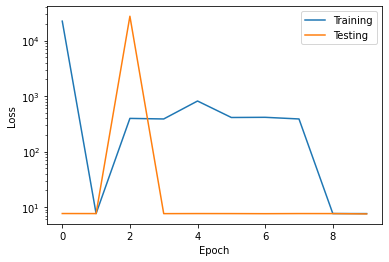

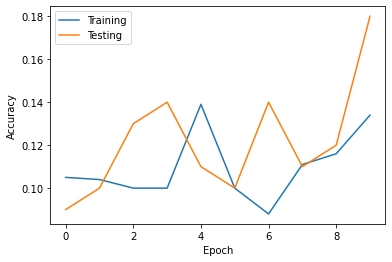

In [7]:
modelName = 'nmnist'
trainedFolder = 'Trained'
os.makedirs(trainedFolder, exist_ok=True)

for epoch in range(10):
    # train
    assist.train(epoch)

    # test
    assist.test(epoch)

    # Update stats.
    stats.update()

    # plot lerarning stats, save stats and model
    stats.plot(saveFig=True, path=trainedFolder + '/')
    net.gradFlow(path=trainedFolder + '/')
    if stats.testing.bestAccuracy is True:  torch.save(net.state_dict(), trainedFolder + '/' + modelName + '.pt')            
    stats.save(trainedFolder + '/')

## Plot the Results

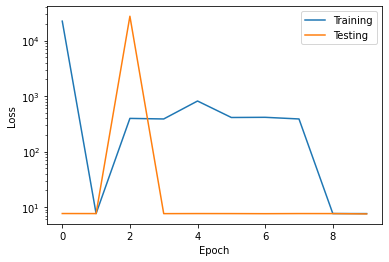

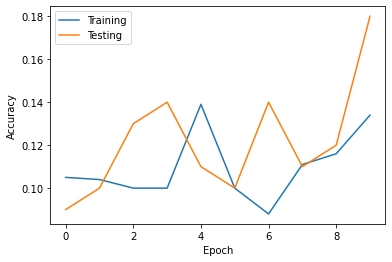

In [8]:
# Plot the results.
# Learning loss
plt.figure(1)
plt.semilogy(stats.training.lossLog, label='Training')
plt.semilogy(stats.testing .lossLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Learning accuracy
plt.figure(2)
plt.plot(stats.training.accuracyLog, label='Training')
plt.plot(stats.testing .accuracyLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Export network
Generate hdf5 encapsulated Loihi network.

In [9]:
# load the best model
net.load_state_dict(torch.load(trainedFolder + '/' + modelName + '.pt'))

# export the model
net.genModel(trainedFolder + '/' + modelName + '.net')